In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns # For enhanced visualisatons


#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#  Change File Path to use on main data file.
file_path = 'csv\cleaned_csv\pp-complete_cleaned_data.csv' 
#  Change File Path to use on main data file.
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Col names for reference:
# "transaction_id", "price", "date_of_transfer","postcode", "property_type", "old_new", "duration", "paon", "saon", "street", "locality", "town_city", "district", "county", "ppd_category_type", "record_status"
cols_needed = ["price", "date_of_transfer", "town_city", "county"]

# Import csv into df with chunking, as i'm only going to analyse properties sold after 2020
chunks = [] # initialise list to add chunkcs to for concatination later.
chunksize = 75_000
for chunk in pd.read_csv(file_path, usecols=cols_needed, chunksize=chunksize):
    chunk['date_of_transfer'] = pd.to_datetime(chunk['date_of_transfer'], errors='coerce') # turn date into datetime value
    chunk = chunk[chunk["date_of_transfer"] >= "2020-01-01"] # only want data after 2020, as cheapest town will be skewed to town that sold the most in 1995...
    chunks.append(chunk)


df = pd.concat(chunks, ignore_index=True)

In [3]:
df_o1 = df.copy()

In [4]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
# This caps the lowest 1% & the Highest 1% to prevent scewed data.
lower_limit, upper_limit = df_o1['price'].quantile([0.01, 0.99])  
df_o1 = df_o1[(df_o1['price'] >= lower_limit) & (df_o1['price'] <= upper_limit)]
# Consider removing when not doing test and using full df_o1
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [5]:
# create a year column
df_o1['year_of_transfer'] = df_o1['date_of_transfer'].dt.year

In [6]:
# create a dictionary for the last 4 years, so i can loop through the dicts later and plot them within a subsplot
years = [2024, 2023, 2022, 2021, 2020]
dict_years = {year: df_o1[df_o1['year_of_transfer'] == year] for year in years}

Text(0.5, 0.98, 'Distribution of House Prices in the United Kingdom (2020-2024)')

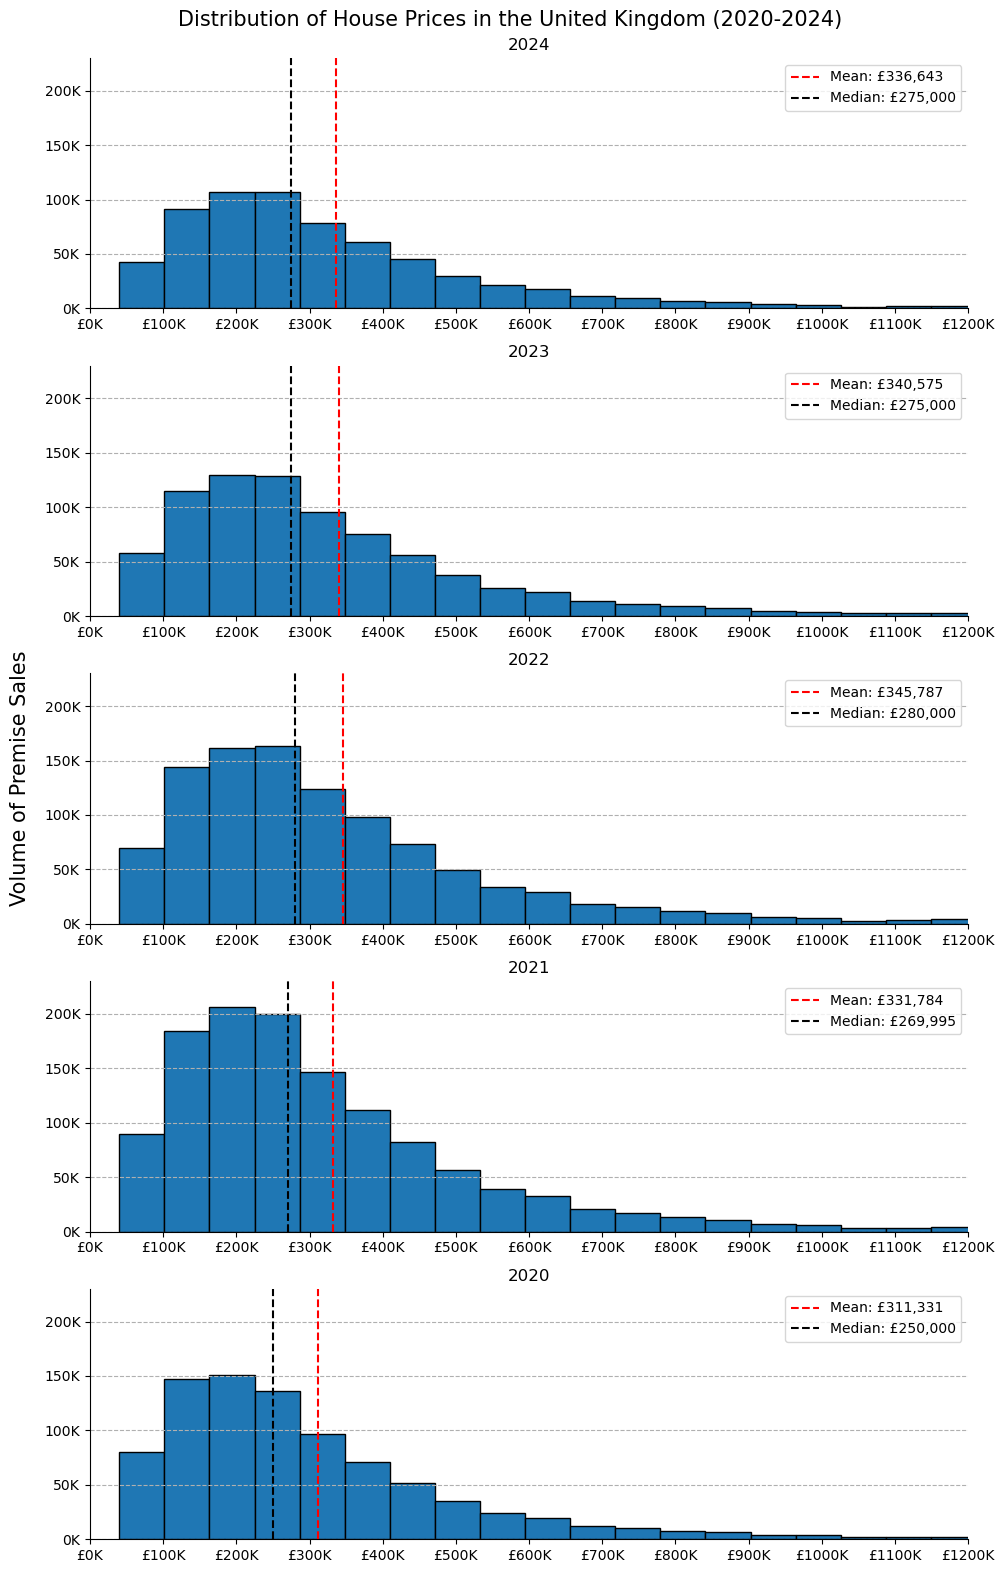

In [28]:
fig, ax = plt.subplots(5,1, figsize=(10,16))
#plotgrid = sns.displot(df_top_4_2024['price'], bins=31, height=6, aspect=1.8)
for i, year in enumerate (years):
    dict_years[year]['price'].plot(
        kind='hist',
        bins=31,
        edgecolor='black',
        ax=ax[i],
        title=year
        )


    # calculate the mean price for each year, so i can plot this below:
    yearly_mean_price = dict_years[year]['price'].mean() 
    ax[i].axvline(yearly_mean_price, color='red', linestyle='--', linewidth=1.5)
    mean_legend_line = mlines.Line2D([], [],color='red', linestyle='--', linewidth=1.5) # set mean line for use in the legend

    # calculate the median price for each year, so i can plot this below:
    yearly_median_price = dict_years[year]['price'].median() 
    ax[i].axvline(yearly_median_price, color='black', linestyle='--', linewidth=1.5)
    median_legend_line = mlines.Line2D([], [],color='black', linestyle='--', linewidth=1.5) # set median line type to use in legend
    
    ax[i].legend(
        [mean_legend_line, median_legend_line],
        [f'Mean: £{yearly_mean_price:,.0f}', f'Median: £{yearly_median_price:,.0f}'],
        loc='upper right'
        ) # uses the line types created above for the legend


    ax[i].set_xticks(np.arange(0,1_200_001, 100_000)) # consitent scale
    ax[i].set_xlim(0, 1_200_000) # startrs the x lim at 0.
    ax[i].set_ylim(0,230_000)
    ax[i].ticklabel_format(style='plain', axis='x')
    ax[i].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'£{int(x/1000)}K'))
    ax[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'{int(y/1000)}K'))
    ax[i].set_ylabel("")
    ax[i].grid(axis= 'y', linestyle = '--')
    ax[i].spines['top'].set_visible(False) # remove top outer line
    ax[i].spines['right'].set_visible(False) # remove right side outer line
    

fig.tight_layout()
fig.text(0, 0.5, 'Volume of Premise Sales', va='center', rotation='vertical', fontsize=15)
fig.subplots_adjust(left=0.08, top=0.95)
fig.suptitle('Distribution of House Prices in the United Kingdom (2020-2024)', fontsize=15)